# Predicting SWE by Deep Neural Networks

In [46]:
from __future__ import print_function
from preprocessing import *
import numpy as np
np.random.seed(2333)  # for reproducibility

import os
import time
import numpy as np
import h5py

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from STResNet import stresnet
import metrics as metrics

Using TensorFlow backend.


In [4]:
def build_model():
    model = stresnet(c_conf=(time_size, nb_channel, 52, 52), nb_residual_unit = 12)
    
    adam = Adam(lr=lr)
    model.compile(loss='mse', optimizer=adam, metrics=[metrics.metrics])

    model.summary()

    return model

In [47]:
# set traing parameters
nb_epoch = 500  # number of epoch at training stage
nb_epoch_cont = 100  # number of epoch at training (cont) stage
batch_size = 32  # batch size
lr = 0.0002  # learning rate
nb_residual_unit = 12  # number of residual units

nb_channel = 1  # there are two types of flows: inflow and outflow
map_height, map_width = 52, 52  # grid size
path_result = 'RET'
path_model = 'MODEL'

# parameter initialization
train_size = 2000
test_size = 100
time_size = 30

if os.path.isdir(path_result) is False:
    os.mkdir(path_result)
if os.path.isdir(path_model) is False:
    os.mkdir(path_model)

In [48]:
# load_data
print("loading data...")
H = load_data('data.mat')

# generate training data & test data
print("generate data from data.mat")
Data = H[-train_size-test_size:, ]

mmn = MinMaxNormalization()
mmn.fit(Data)
X_train, y_train = init_data(Data, train_size, time_size)
X_test, y_test = init_data(Data[train_size:, ], test_size, time_size)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

loading data...
generate data from data.mat
min: 0.813698642656 max: 1.4387486436
(1970, 30, 52, 52)
(1970, 1, 52, 52)
(70, 30, 52, 52)
(70, 1, 52, 52)


In [22]:
print(H.shape)

(10000, 2704)


In [12]:
# build model
model = build_model()

ts = time.time()
hyperparams_name = 'train_size{}.test_size{}.time_size{}.resunit{}.lr{}'.format(
    train_size, test_size, time_size, nb_residual_unit, lr)
fname_param = os.path.join('MODEL', '{}.best.h5'.format(hyperparams_name))

early_stopping = EarlyStopping(monitor='val_rmse', patience=2, mode='min')
model_checkpoint = ModelCheckpoint(
    fname_param, monitor='rmse', verbose=0, save_best_only=True, mode='min')

print("\nelapsed time (compiling model): %.3f seconds\n" %
    (time.time() - ts))

print('=' * 10)

'''
print("load weight...")

model.load_weights(os.path.join('MODEL', 'train_size1000.test_size100.time_size30.resunit12.lr0.0002.final.best.h5'))
print('=' * 10)
'''

print("training model...")
ts = time.time()

history = model.fit(X_train, y_train, nb_epoch=2, verbose=1, batch_size=batch_size, callbacks=[
                        model_checkpoint])
print("\nelapsed time (training cont): %.3f seconds\n" % (time.time() - ts))

json_string = model.to_json()
open('model_json', 'w').write(json_string)
#model = model_from_json(json_string)
model.save_weights(os.path.join('MODEL', '{}.final.best.h5'.format(hyperparams_name)), overwrite=True)

print('=' * 10)
ts = time.time()
score = model.evaluate(
    X_test, y_test, batch_size=y_test.shape[0], verbose=0)
print('Test score: %.6f rmse (norm): %.6f rmse (real): %.6f' %
    (score[0], score[1], score[1] * (mmn._max - mmn._min) / 2.))
print("\nelapsed time (eval cont): %.3f seconds\n" % (time.time() - ts))

/Users/wq/Desktop/OST/OST/STResNet.py:56: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=64, padding="same")`
  nb_filter=64, nb_row=3, nb_col=3, border_mode="same")(input)
/Users/wq/Desktop/OST/OST/STResNet.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=64, strides=(1, 1), padding="same")`
  return Convolution2D(nb_filter=nb_filter, nb_row=nb_row, nb_col=nb_col, subsample=subsample, border_mode="same")(activation)
/Users/wq/Desktop/OST/OST/STResNet.py:14: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return merge([input, residual], mode='sum')
/Users/wq/anaconda3/envs/tensorflow-r1.0/lib/python3.5/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 30, 52, 52)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 52, 52)        17344     
_________________________________________________________________
activation_27 (Activation)   (None, 64, 52, 52)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 52, 52)        36928     
_________________________________________________________________
activation_28 (Activation)   (None, 64, 52, 52)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 52, 52)        36928     
_________________________________________________________________
merge_13 (Merge)             (None, 64, 52, 52)        0         
__________

/Users/wq/anaconda3/envs/tensorflow-r1.0/lib/python3.5/site-packages/ipykernel/__main__.py:29: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/2
1970/1970 [==============================] - 1080s - loss: 0.1284 - root_mean_square_error: 0.1282     

/Users/wq/anaconda3/envs/tensorflow-r1.0/lib/python3.5/site-packages/keras/callbacks.py:388: RuntimeWarning: Can save best model only with rmse available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)



Epoch 2/2
1970/1970 [==============================] - 984s - loss: 0.0036 - root_mean_square_error: 0.0603     

In [14]:
print(history.history)

{'loss': [0.12841709654395311, 0.003635508968698116], 'root_mean_square_error': [0.12818470455819581, 0.060289377072438373]}


## exp with different residual units

In [2]:
import pickle as pickle

In [13]:
nb_residual_unit = 3
train_size = 3000
test_size = 300
time_size = 30
hyperparams_name = 'train_size{}.test_size{}.time_size{}.resunit{}.lr{}'.format(
    train_size, test_size, time_size, nb_residual_unit, lr)

In [17]:
nb_residual_unit = 3
with open(os.path.join('RET',"{}.history.pkl".format(hyperparams_name)), "rb") as f:
    history_3 = pickle.load(f)
with open(os.path.join('RET',"{}.cont.history.pkl".format(hyperparams_name)), "rb") as f:
    history_3_cont = pickle.load(f)

In [18]:
nb_residual_unit = 6
with open(os.path.join('RET',"{}.history.pkl".format(hyperparams_name)), "rb") as f:
    history_6 = pickle.load(f)
with open(os.path.join('RET',"{}.cont.history.pkl".format(hyperparams_name)), "rb") as f:
    history_6_cont = pickle.load(f)

In [19]:
nb_residual_unit = 9
with open(os.path.join('RET',"{}.history.pkl".format(hyperparams_name)), "rb") as f:
    history_9 = pickle.load(f)
with open(os.path.join('RET',"{}.cont.history.pkl".format(hyperparams_name)), "rb") as f:
    history_9_cont = pickle.load(f)

In [20]:
nb_residual_unit = 12
with open(os.path.join('RET',"{}.history.pkl".format(hyperparams_name)), "rb") as f:
    history_12 = pickle.load(f)
with open(os.path.join('RET',"{}.cont.history.pkl".format(hyperparams_name)), "rb") as f:
    history_12_cont = pickle.load(f)

In [5]:
import matplotlib.pyplot as plt
import os

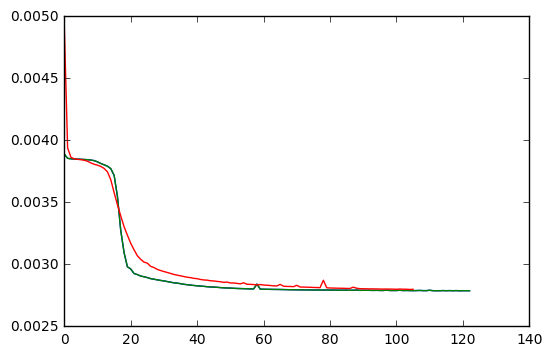

In [45]:
with open(os.path.join('RET',"train_size3000.test_size300.time_size3.resunit1.lr0.0001.history.pkl"), "rb") as f:
    history = pickle.load(f)
plt.plot(history['loss'][1:])
with open(os.path.join('RET',"train_size3000.test_size300.time_size3.resunit2.lr3e-05.history.pkl"), "rb") as f:
    history1 = pickle.load(f)
plt.plot(history1['loss'][1:], 'r')
plt.show()

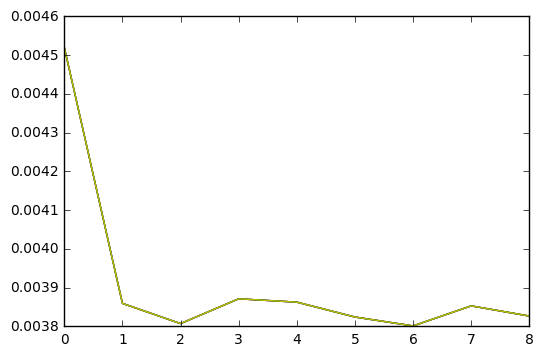

In [31]:
plt.plot(history_3['loss'], "r")
plt.plot(history_6['loss'], "b")
plt.plot(history_9['loss'], "g")
plt.plot(history_12['loss'], "y")
plt.show()

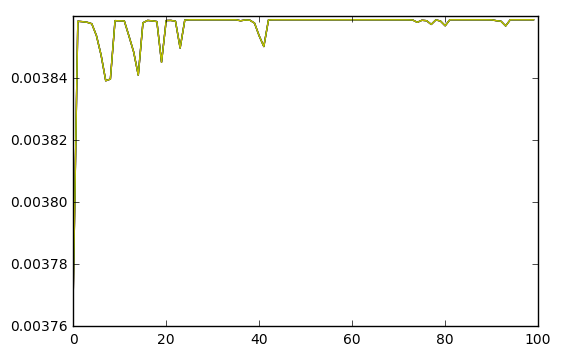

In [32]:
plt.plot(history_3_cont['loss'], "r")
plt.plot(history_6_cont['loss'], "b")
plt.plot(history_9_cont['loss'], "g")
plt.plot(history_12_cont['loss'], "y")
plt.show()

In [33]:
print(history_3_cont['loss'])

[0.0037693378225483174, 0.0038584518078589179, 0.0038583122839781171, 0.0038581169475346601, 0.0038576471732195581, 0.0038538198609231198, 0.0038475493514778638, 0.0038392581835840689, 0.003839799454937429, 0.0038586412882589132, 0.0038586047098592476, 0.0038585335549330873, 0.0038536494647964884, 0.0038485829219824137, 0.0038410712485060549, 0.003857945335985033, 0.0038587110077880748, 0.0038585797949421286, 0.0038583429961430806, 0.0038452375355656401, 0.0038586841441490233, 0.0038587162703877746, 0.0038584697627860689, 0.0038498158619961753, 0.003858820284851623, 0.0038589374516598304, 0.0038589371738309412, 0.0038589368742084763, 0.003858936508421344, 0.0038589360777238502, 0.003858935512188408, 0.0038589347950386682, 0.0038589337661937631, 0.0038589322205745814, 0.0038589295993875774, 0.0038589202359895713, 0.0038585997810618644, 0.0038588748780715746, 0.0038587916259863963, 0.0038578393187072841, 0.0038537442536792569, 0.0038503016843789758, 0.0038588852698441204, 0.0038589399972